# ОИАД. Лабораторная работа №2

## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 слобкика данных по формулам:
1) N % 5
2) N^2 % 5 + 5 


где $N$ - номер в списке

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../datasets/students_simple.csv')

N = 4
col1 = N % 5
col2 = (N**2) % 5 + 5

x = df.iloc[:, col1].dropna()
y = df.iloc[:, col2].dropna()

common_idx = x.index.intersection(y.index)
x = x.loc[common_idx]
y = y.loc[common_idx]

print(f"Размер выборки: {len(x)}")
print(f"Столбец 1: {df.columns[col1]}")
print(f"Столбец 2: {df.columns[col2]}")

Размер выборки: 20
Столбец 1: pages
Столбец 2: bmi


## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

In [7]:
def fechner_corr(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_sign = np.sign(x - x_mean)
    y_sign = np.sign(y - y_mean)
    
    concordant = np.sum(x_sign * y_sign > 0)
    discordant = np.sum(x_sign * y_sign < 0)
    
    if (concordant + discordant) == 0:
        return 0
    return (concordant - discordant) / (concordant + discordant)

fechner = fechner_corr(x, y)
pearson, pearson_p = stats.pearsonr(x, y)
spearman, spearman_p = stats.spearmanr(x, y)
kendall, kendall_p = stats.kendalltau(x, y)


# Доверительный интервал для Пирсона
n = len(x)
z = np.arctanh(pearson)
se = 1 / np.sqrt(n - 3)
z_lower = z - 1.96 * se
z_upper = z + 1.96 * se
pearson_ci_low = np.tanh(z_lower)
pearson_ci_high = np.tanh(z_upper)

print("\n" + "="*50)
print("1. РЕЗУЛЬТАТЫ КОРРЕЛЯЦИОННОГО АНАЛИЗА")
print("="*50)
print(f"Корреляция Фехнера: {fechner:.4f}")
print(f"Корреляция Пирсона: {pearson:.4f}")
print(f"Доверительный интервал Пирсона (95%): ({pearson_ci_low:.4f}, {pearson_ci_high:.4f})")
print(f"Корреляция Спирмена: {spearman:.4f}")
print(f"Корреляция Кендалла: {kendall:.4f}")


1. РЕЗУЛЬТАТЫ КОРРЕЛЯЦИОННОГО АНАЛИЗА
Корреляция Фехнера: -0.4000
Корреляция Пирсона: -0.1795
Доверительный интервал Пирсона (95%): (-0.5763, 0.2857)
Корреляция Спирмена: -0.3239
Корреляция Кендалла: -0.2442


Корреляция Фехнера: -0.4000 говорит о том что 40% всех пар имеют согласованную зависимость в отклонении от среднего и она обратная.

Корреляция Пирсона: -0.1795 - очень слабая статистическая зависимость, к тому же доверительный интервал включает в себя 0. 

Корреляция Спирмена: -0.3239 - говорит о том что при ранжировании данных наблюдается небольшая обратная зависимость 

Корреляция Кендалла: -0.2442 - говорит о том что несогласовнных пар на 24 процента больше чем согласованных

In [ ]:
import math
import numpy as np

def fechner_correlation(x, y):
    """
    Самописная реализация корреляции Фехнера
    """
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    n = len(x)
    concordant = 0
    discordant = 0
    
    for i in range(n):
        x_sign = 1 if x[i] > x_mean else (-1 if x[i] < x_mean else 0)
        y_sign = 1 if y[i] > y_mean else (-1 if y[i] < y_mean else 0)
        
        if x_sign * y_sign > 0:
            concordant += 1
        elif x_sign * y_sign < 0:
            discordant += 1
    
    total_pairs = concordant + discordant
    if total_pairs == 0:
        return 0
    
    return (concordant - discordant) / total_pairs

def pearson_correlation(x, y):
    """
    Самописная реализация корреляции Пирсона с доверительным интервалом
    """
    n = len(x)
    
    # Вычисляем средние
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # Вычисляем ковариацию и дисперсии
    covariance = 0
    var_x = 0
    var_y = 0
    
    for i in range(n):
        dx = x[i] - x_mean
        dy = y[i] - y_mean
        covariance += dx * dy
        var_x += dx * dx
        var_y += dy * dy
    
    # Корреляция Пирсона
    if var_x == 0 or var_y == 0:
        r = 0
    else:
        r = covariance / math.sqrt(var_x * var_y)
    
    # Доверительный интервал с использованием z-преобразования Фишера
    if abs(r) < 0.999 and n > 3:
        # z-преобразование
        z = 0.5 * math.log((1 + r) / (1 - r))
        
        # Стандартная ошибка
        se = 1 / math.sqrt(n - 3)
        
        # Доверительный интервал для z
        z_lower = z - 1.96 * se
        z_upper = z + 1.96 * se
        
        # Обратное преобразование к r
        r_lower = (math.exp(2 * z_lower) - 1) / (math.exp(2 * z_lower) + 1)
        r_upper = (math.exp(2 * z_upper) - 1) / (math.exp(2 * z_upper) + 1)
    else:
        r_lower, r_upper = r, r
    
    return r, (r_lower, r_upper)

def spearman_correlation(x, y):
    """
    Самописная реализация корреляции Спирмена
    """
    n = len(x)
    
    # Функция для вычисления рангов
    def get_ranks(data):
        sorted_data = sorted(data)
        ranks = []
        for value in data:
            # Находим все позиции с таким значением (для учета связей)
            positions = [i for i, v in enumerate(sorted_data) if v == value]
            rank = sum(positions) / len(positions) + 1  # Средний ранг для связей
            ranks.append(rank)
        return ranks
    
    # Получаем ранги
    ranks_x = get_ranks(x)
    ranks_y = get_ranks(y)
    
    # Вычисляем разности рангов
    d_squared_sum = 0
    for i in range(n):
        d = ranks_x[i] - ranks_y[i]
        d_squared_sum += d * d
    
    # Корреляция Спирмена
    if n <= 1:
        return 0
    
    rho = 1 - (6 * d_squared_sum) / (n * (n * n - 1))
    return rho

def kendall_correlation(x, y):
    """
    Самописная реализация корреляции Кендалла
    """
    n = len(x)
    
    concordant = 0
    discordant = 0
    
    # Проверяем все пары (i, j) где i < j
    for i in range(n):
        for j in range(i + 1, n):
            x_diff = x[i] - x[j]
            y_diff = y[i] - y[j]
            
            product = x_diff * y_diff
            
            if product > 0:
                concordant += 1  # Одинаковое направление
            elif product < 0:
                discordant += 1  # Разное направление
    
    total_pairs = concordant + discordant
    if total_pairs == 0:
        return 0
    
    tau = (concordant - discordant) / total_pairs
    return tau

# Тестирование функций
print("САМОПИСНЫЕ РЕАЛИЗАЦИИ КОРРЕЛЯЦИЙ:")
print("="*50)

fechner_manual = fechner_correlation(x, y)
pearson_manual, pearson_ci_manual = pearson_correlation(x, y)
spearman_manual = spearman_correlation(x, y)
kendall_manual = kendall_correlation(x, y)

print(f"Фехнер (самописный): {fechner_manual:.4f}")
print(f"Пирсон (самописный): {pearson_manual:.4f}")
print(f"Доверительный интервал Пирсона: ({pearson_ci_manual[0]:.4f}, {pearson_ci_manual[1]:.4f})")
print(f"Спирмен (самописный): {spearman_manual:.4f}")
print(f"Кендалл (самописный): {kendall_manual:.4f}")

# Сравнение с библиотечными реализациями (если они доступны)
print("\nСРАВНЕНИЕ С БИБЛИОТЕЧНЫМИ РЕАЛИЗАЦИЯМИ:")
print("="*50)

# Для сравнения используем scipy если доступен
try:
    from scipy import stats
    pearson_lib, _ = stats.pearsonr(x, y)
    spearman_lib, _ = stats.spearmanr(x, y)
    kendall_lib, _ = stats.kendalltau(x, y)
    
    print(f"Пирсон (библиотека): {pearson_lib:.4f}")
    print(f"Спирмен (библиотека): {spearman_lib:.4f}")
    print(f"Кендалл (библиотека): {kendall_lib:.4f}")
    
    print(f"\nРазницы:")
    print(f"Пирсон: {abs(pearson_manual - pearson_lib):.6f}")
    print(f"Спирмен: {abs(spearman_manual - spearman_lib):.6f}")
    print(f"Кендалл: {abs(kendall_manual - kendall_lib):.6f}")
    
except ImportError:
    print("Библиотека scipy недоступна для сравнения")

САМОПИСНЫЕ РЕАЛИЗАЦИИ КОРРЕЛЯЦИЙ:
Фехнер (самописный): -0.4000
Пирсон (самописный): -0.1795
Доверительный интервал Пирсона: (-0.5763, 0.2857)
Спирмен (самописный): -0.3000
Кендалл (самописный): -0.2638

СРАВНЕНИЕ С БИБЛИОТЕЧНЫМИ РЕАЛИЗАЦИЯМИ:
Пирсон (библиотека): -0.1795
Спирмен (библиотека): -0.3239
Кендалл (библиотека): -0.2442

Разницы:
Пирсон: 0.000000
Спирмен: 0.023940
Кендалл: 0.019564


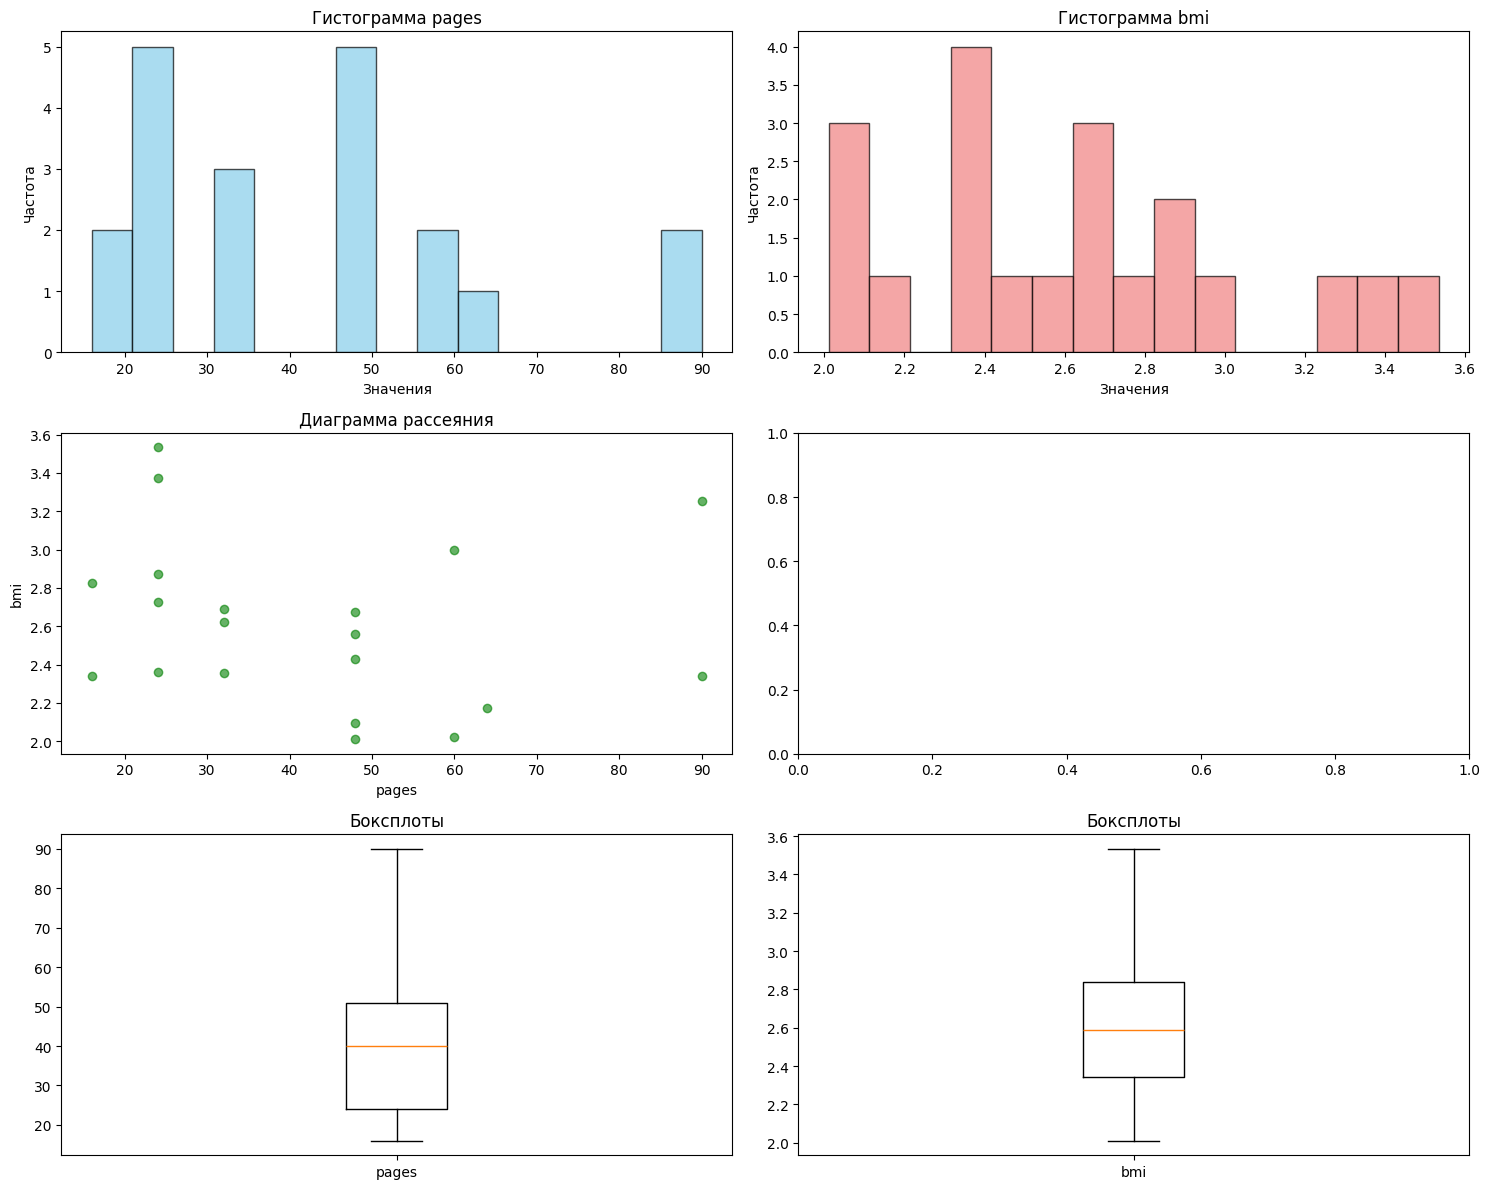


ОСНОВНЫЕ СТАТИСТИКИ:
X (pages):
  Среднее: 42.60, Медиана: 40.00, STD: 21.43
Y (bmi):
  Среднее: 2.61, Медиана: 2.59, STD: 0.43


In [29]:
# Создание графиков
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Гистограмма X
axes[0, 0].hist(x, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title(f'Гистограмма {df.columns[col1]}')
axes[0, 0].set_xlabel('Значения')
axes[0, 0].set_ylabel('Частота')

# Гистограмма Y
axes[0, 1].hist(y, bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title(f'Гистограмма {df.columns[col2]}')
axes[0, 1].set_xlabel('Значения')
axes[0, 1].set_ylabel('Частота')

# Scatter plot
axes[1, 0].scatter(x, y, alpha=0.6, color='green')
axes[1, 0].set_title('Диаграмма рассеяния')
axes[1, 0].set_xlabel(f'{df.columns[col1]}')
axes[1, 0].set_ylabel(f'{df.columns[col2]}')

# Box plots
axes[2, 0].boxplot(x, labels=[df.columns[col1]])
axes[2, 0].set_title('Боксплоты')

axes[2, 1].boxplot(y, labels=[df.columns[col2]])
axes[2, 1].set_title('Боксплоты')

plt.tight_layout()
plt.show()

# Дополнительная информация о данных
print("\nОСНОВНЫЕ СТАТИСТИКИ:")
print(f"X ({df.columns[col1]}):")
print(f"  Среднее: {np.mean(x):.2f}, Медиана: {np.median(x):.2f}, STD: {np.std(x):.2f}")
print(f"Y ({df.columns[col2]}):")
print(f"  Среднее: {np.mean(y):.2f}, Медиана: {np.median(y):.2f}, STD: {np.std(y):.2f}")

In [37]:
from scipy.stats import shapiro

def analyze_histogram(data):
    mean_data = np.mean(data)
    median_data = np.median(data)
    std_data = np.std(data)
    if len(data) > 3 and len(data) < 5000:
        stat, p_value = shapiro(data)
        print(f"\nТест Шапиро-Уилка на нормальность: p-value = {p_value:.4f}")
        if p_value > 0.05:
            print("  Распределение не отличается от нормального")
        else:
            print("  Распределение отличается от нормального")

analyze_histogram(x)
analyze_histogram(y)


Тест Шапиро-Уилка на нормальность: p-value = 0.0249
  Распределение отличается от нормального

Тест Шапиро-Уилка на нормальность: p-value = 0.3520
  Распределение не отличается от нормального


гистограмма pages : почти симметричное распределение, две моды(24 и 48), не явл нормальным распределением.

гистограмма bmi : стат тест шапиро уилка показывает что распределение является нормальным, большая часть данных скошена в левую часть.

диаграмма рассеяния : на ней не видно каких-то зависимостей, точки как будто просто рандомным образом находятся на плоскости. Но большая часть сконцентрирована в нижней левой четверти диаграммы.

боксплот для pages : нет выбросов, видно что разброс значение справа от медианы гораздо сильнее, че слева.

боксплот для bmi : нет выбросов, видна небольшая тенденция скопления данных справа от медианы чуть больше чем слева.

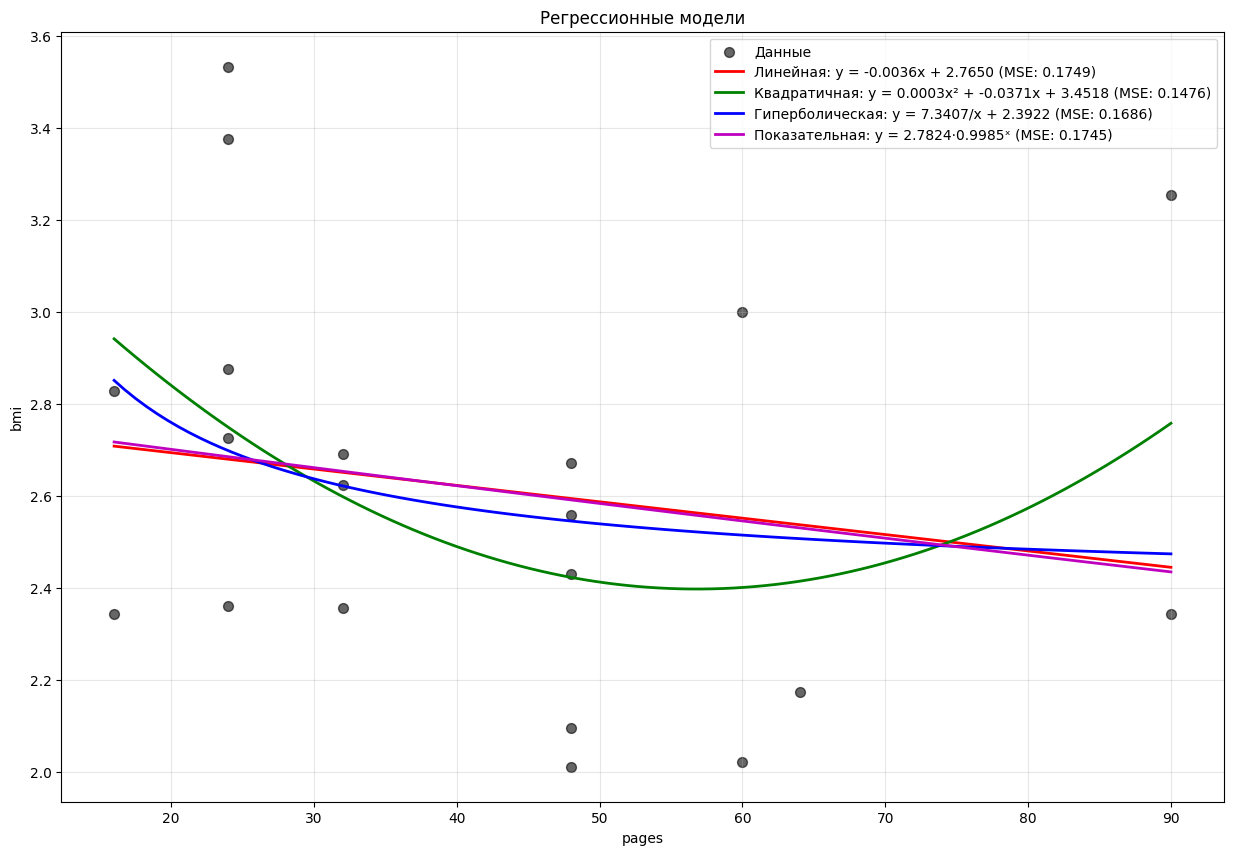


СРАВНЕНИЕ МОДЕЛЕЙ (по MSE):
  Квадратичная: 0.1476
  Гиперболическая: 0.1686
  Показательная: 0.1745
  Линейная: 0.1749
Лучшая модель: Квадратичная
Худшая модель: Линейная


In [10]:
# Определение функций для регрессии
def linear_func(x, w1, w0):
    return w1 * x + w0

def quadratic_func(x, w2, w1, w0):
    return w2 * x**2 + w1 * x + w0

def hyperbolic_func(x, w1, w0):
    return w1 / x + w0

def exponential_func(x, w1, w0):
    return w0 * (w1 ** x)

# Подгонка моделей
try:
    popt_linear, pcov_linear = curve_fit(linear_func, x, y)
    y_pred_linear = linear_func(x, *popt_linear)
    mse_linear = np.mean((y - y_pred_linear)**2)
except:
    mse_linear = float('inf')

try:
    popt_quad, pcov_quad = curve_fit(quadratic_func, x, y)
    y_pred_quad = quadratic_func(x, *popt_quad)
    mse_quad = np.mean((y - y_pred_quad)**2)
except:
    mse_quad = float('inf')

try:
    popt_hyp, pcov_hyp = curve_fit(hyperbolic_func, x, y)
    y_pred_hyp = hyperbolic_func(x, *popt_hyp)
    mse_hyp = np.mean((y - y_pred_hyp)**2)
except:
    mse_hyp = float('inf')

try:
    popt_exp, pcov_exp = curve_fit(exponential_func, x, y, maxfev=5000)
    y_pred_exp = exponential_func(x, *popt_exp)
    mse_exp = np.mean((y - y_pred_exp)**2)
except:
    mse_exp = float('inf')

# Создание графика с регрессиями
plt.figure(figsize=(15, 10))

# Исходные данные
plt.scatter(x, y, alpha=0.6, color='black', label='Данные', s=50)

# Сортировка для плавных линий
x_sorted = np.sort(x)
x_cont = np.linspace(x.min(), x.max(), 100)

# Линейная регрессия
if mse_linear != float('inf'):
    y_linear = linear_func(x_cont, *popt_linear)
    plt.plot(x_cont, y_linear, 'r-', linewidth=2, 
             label=f'Линейная: y = {popt_linear[0]:.4f}x + {popt_linear[1]:.4f} (MSE: {mse_linear:.4f})')

# Квадратичная регрессия
if mse_quad != float('inf'):
    y_quad = quadratic_func(x_cont, *popt_quad)
    plt.plot(x_cont, y_quad, 'g-', linewidth=2, 
             label=f'Квадратичная: y = {popt_quad[0]:.4f}x² + {popt_quad[1]:.4f}x + {popt_quad[2]:.4f} (MSE: {mse_quad:.4f})')

# Гиперболическая регрессия
if mse_hyp != float('inf'):
    y_hyp = hyperbolic_func(x_cont, *popt_hyp)
    plt.plot(x_cont, y_hyp, 'b-', linewidth=2, 
             label=f'Гиперболическая: y = {popt_hyp[0]:.4f}/x + {popt_hyp[1]:.4f} (MSE: {mse_hyp:.4f})')

# Показательная регрессия
if mse_exp != float('inf'):
    y_exp = exponential_func(x_cont, *popt_exp)
    plt.plot(x_cont, y_exp, 'm-', linewidth=2, 
             label=f'Показательная: y = {popt_exp[1]:.4f}·{popt_exp[0]:.4f}ˣ (MSE: {mse_exp:.4f})')

plt.xlabel(f'{df.columns[col1]}')
plt.ylabel(f'{df.columns[col2]}')
plt.title('Регрессионные модели')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Сравнение моделей
models = {
    'Линейная': mse_linear,
    'Квадратичная': mse_quad,
    'Гиперболическая': mse_hyp,
    'Показательная': mse_exp
}

valid_models = {k: v for k, v in models.items() if v != float('inf')}
if valid_models:
    best_model = min(valid_models, key=valid_models.get)
    worst_model = max(valid_models, key=valid_models.get)
    
    print(f"\nСРАВНЕНИЕ МОДЕЛЕЙ (по MSE):")
    for model, mse in sorted(valid_models.items(), key=lambda x: x[1]):
        print(f"  {model}: {mse:.4f}")
    print(f"Лучшая модель: {best_model}")
    print(f"Худшая модель: {worst_model}")

по каждой из кривых видно что они не могут нормально уловить зависимость в данных так как они(точки) имеют очень сильных разброс

In [11]:
def fisher_test(y_true, y_pred, k, alpha=0.05):
    """
    Критерий Фишера для проверки адекватности модели
    """
    n = len(y_true)
    ss_residual = np.sum((y_true - y_pred)**2)
    ss_total = np.sum((y_true - np.mean(y_true))**2)
    ss_regression = ss_total - ss_residual
    
    # Степени свободы
    df_regression = k - 1
    df_residual = n - k
    
    if df_residual <= 0 or df_regression <= 0:
        return None, None, None
    
    # Средние квадраты
    ms_regression = ss_regression / df_regression
    ms_residual = ss_residual / df_residual
    
    # F-статистика
    f_statistic = ms_regression / ms_residual if ms_residual != 0 else float('inf')
    
    # Критическое значение F
    f_critical = stats.f.ppf(1 - alpha, df_regression, df_residual)
    
    return f_statistic, f_critical, f_statistic > f_critical

# Проверка для лучшей и худшей моделей
print("\nПРОВЕРКА КРИТЕРИЕМ ФИШЕРА:")

# Лучшая модель
if best_model == 'Линейная':
    y_pred_best = y_pred_linear
    k_best = 2  # количество параметров
elif best_model == 'Квадратичная':
    y_pred_best = y_pred_quad
    k_best = 3
elif best_model == 'Гиперболическая':
    y_pred_best = y_pred_hyp
    k_best = 2
elif best_model == 'Показательная':
    y_pred_best = y_pred_exp
    k_best = 2

f_stat_best, f_crit_best, adequate_best = fisher_test(y, y_pred_best, k_best)

print(f"\n{best_model} модель (лучшая):")
print(f"  F-статистика: {f_stat_best:.4f}")
print(f"  Критическое значение F: {f_crit_best:.4f}")
print(f"  Модель адекватна: {'ДА' if adequate_best else 'НЕТ'}")

# Худшая модель
if worst_model == 'Линейная':
    y_pred_worst = y_pred_linear
    k_worst = 2
elif worst_model == 'Квадратичная':
    y_pred_worst = y_pred_quad
    k_worst = 3
elif worst_model == 'Гиперболическая':
    y_pred_worst = y_pred_hyp
    k_worst = 2
elif worst_model == 'Показательная':
    y_pred_worst = y_pred_exp
    k_worst = 2

f_stat_worst, f_crit_worst, adequate_worst = fisher_test(y, y_pred_worst, k_worst)

print(f"\n{worst_model} модель (худшая):")
print(f"  F-статистика: {f_stat_worst:.4f}")
print(f"  Критическое значение F: {f_crit_worst:.4f}")
print(f"  Модель адекватна: {'ДА' if adequate_worst else 'НЕТ'}")


ПРОВЕРКА КРИТЕРИЕМ ФИШЕРА:

Квадратичная модель (лучшая):
  F-статистика: 1.9036
  Критическое значение F: 3.5915
  Модель адекватна: НЕТ

Линейная модель (худшая):
  F-статистика: 0.5993
  Критическое значение F: 4.4139
  Модель адекватна: НЕТ
